In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import os,gc,re,time
import matplotlib.pyplot as plt
import seaborn as sns
import spacy,random
from collections import Counter
import warnings,unicodedata
warnings.simplefilter("ignore")


#setting device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Available device: {device}')

Available device: cpu


In [3]:

# colab
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/translation')


Mounted at /content/drive


## Data

In [47]:
train_csv_path,val_csv_path,test_csv_path = 'data/train_30.csv','data/val_30.csv','data/test.csv'
df_train = pd.read_csv(train_csv_path).loc[:60000]
df_val = pd.read_csv(val_csv_path).loc[:2000]
df_test = pd.read_csv(test_csv_path)

print(df_train.shape,df_val.shape,df_test.shape)
df_train.head()

(60001, 2) (2001, 2) (1000, 2)


,English,Ger
0,Two young White males are outside near many b...,Zwei junge weiße Männer sind im Freien in der ...
1,Several men in hard hats are operating a giant...,Mehrere Männer mit Schutzhelmen bedienen ein A...
2,A little girl climbing into a wooden playhouse.,Ein kleines Mädchen klettert in ein Spielhaus ...
3,A man in a blue shirt is standing on a ladder ...,Ein Mann in einem blauen Hemd steht auf einer ...
4,Two men are at the stove preparing food.,Zwei Männer stehen am Herd und bereiten Essen zu.


In [48]:
# preprocess
from utils.utils import clean_eng_text,clean_ger_text

# drop the duplicate
df_train = df_train.drop_duplicates()

# clean the text remove punctuation, upper-lower case
df_train["English"] = df_train["English"].apply(lambda x: clean_eng_text(x))
df_train["Ger"] = df_train["Ger"].apply(lambda x: clean_ger_text(x))

df_val["English"] = df_val["English"].apply(lambda x: clean_eng_text(x))
df_val["Ger"] = df_val["Ger"].apply(lambda x: clean_ger_text(x))

df_test["English"] = df_test["English"].apply(lambda x: clean_eng_text(x))
df_test["Ger"] = df_test["Ger"].apply(lambda x: clean_ger_text(x))


In [35]:
df_train.head()

,English,Ger
0,two young white males are outside near many bu...,Zwei junge weiße Männer sind im Freien in der ...
1,several men in hard hats are operating a giant...,Mehrere Männer mit Schutzhelmen bedienen ein A...
2,a little girl climbing into a wooden playhouse,Ein kleines Mädchen klettert in ein Spielhaus ...
3,a man in a blue shirt is standing on a ladder ...,Ein Mann in einem blauen Hemd steht auf einer ...
4,two men are at the stove preparing food,Zwei Männer stehen am Herd und bereiten Essen zu


In [5]:
# generate vocabulary
!python -m spacy download de_core_news_sm
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.6/14.6 MB 89.8 MB/s eta 0:00:0000:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('de_core_news_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 99.9 MB/s eta 0:00:0000:010:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [49]:
from utils.vocab_generator import VocabGenerator

corpus_eng = ' '.join(list(df_train['English'].values))
vocab_eng = VocabGenerator(corpus=corpus_eng, min_frequency=2,tokenizer_lang="english")

corpus_ger = ' '.join(list(df_train['Ger'].values))
vocab_ger = VocabGenerator(corpus=corpus_ger, min_frequency=2,tokenizer_lang="germen")

print(vocab_ger.stoi)

{'<UNK>': 1, '<PAD>': 0, '<SOS>': 2, '<EOS>': 3, 'Zwei': 4, 'junge': 5, 'weiße': 6, 'Männer': 7, 'sind': 8, 'im': 9, 'Freien': 10, 'in': 11, 'der': 12, 'Nähe': 13, 'vieler': 14, 'Büsche': 15, 'Mehrere': 16, 'mit': 17, 'Schutzhelmen': 18, 'bedienen': 19, 'ein': 20, 'Ein': 21, 'kleines': 22, 'Mädchen': 23, 'klettert': 24, 'Spielhaus': 25, 'aus': 26, 'Holz': 27, 'Mann': 28, 'einem': 29, 'blauen': 30, 'Hemd': 31, 'steht': 32, 'auf': 33, 'einer': 34, 'Leiter': 35, 'und': 36, 'putzt': 37, 'Fenster': 38, 'stehen': 39, 'am': 40, 'Herd': 41, 'bereiten': 42, 'Essen': 43, 'zu': 44, 'grün': 45, 'hält': 46, 'eine': 47, 'Gitarre': 48, 'während': 49, 'andere': 50, 'sein': 51, 'ansieht': 52, 'lächelt': 53, 'einen': 54, 'ausgestopften': 55, 'Löwen': 56, 'an': 57, 'schickes': 58, 'spricht': 59, 'dem': 60, 'Handy': 61, 'sie': 62, 'langsam': 63, 'die': 64, 'Straße': 65, 'Eine': 66, 'Frau': 67, 'großen': 68, 'Geldbörse': 69, 'geht': 70, 'Tor': 71, 'vorbei': 72, 'Jungen': 73, 'tanzen': 74, 'mitten': 75, 'Na

In [50]:
# data loader
from utils.data_loader import LoadTextDataset
from torch.utils.data import DataLoader

batch_size = 8

df_train = df_train.drop(df_train.tail((df_train.shape[0]%batch_size)).index)
df_val = df_val.drop(df_val.tail((df_val.shape[0]%batch_size)).index)
df_test = df_test.drop(df_test.tail((df_test.shape[0]%batch_size)).index)

# 258 words, 260 including eos, sos
train_data = LoadTextDataset(df_train,vocab_ger,vocab_eng,input_seq_length=40,target_seq_length=40,padding=True)
val_data = LoadTextDataset(df_val,vocab_ger,vocab_eng,input_seq_length=40,target_seq_length=40,padding=True)
test_data = LoadTextDataset(df_test,vocab_ger,vocab_eng,input_seq_length=40,target_seq_length=40,padding=True)

# make sure to SHUFFLE your data
train_loader = DataLoader(train_data, batch_size=batch_size)
valid_loader = DataLoader(val_data, batch_size=batch_size)
test_loader = DataLoader(test_data, batch_size=batch_size)

## Model

In [38]:
from transformer import SeqtoSeqTransformer

# params
src_vocab_size = vocab_ger.__len__() -44   # need change
target_vocab_size = vocab_eng.__len__()
# change
max_len_src = 42
max_len_target = 42

embedding_size = 512
num_of_heads = 8
num_of_encoders = 3
num_of_decoders = 3
drop_out = 0.2
num_fwd_expansion = 1024
pad_idx = vocab_ger.stoi["<PAD>"]
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = SeqtoSeqTransformer(src_vocab_size,target_vocab_size,max_len_src,max_len_target,embedding_size,
                 num_of_heads,num_of_encoders,num_of_decoders,pad_idx,
                 drop_out,num_fwd_expansion,device)


# weight initialization
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)
print(device)
model.to(device)

cpu


SeqtoSeqTransformer(
  (src_word_embedding): EmbeddingLayer(
    (embedding): Embedding(24566, 512)
  )
  (src_positional_embedding): PositionalEncoding()
  (target_word_embedding): EmbeddingLayer(
    (embedding): Embedding(13671, 512)
  )
  (target_positional_embedding): PositionalEncoding()
  (transformer): Transformer(
    (encoder): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
          )
          (linear1): Linear(in_features=512, out_features=1024, bias=True)
          (dropout): Dropout(p=0.2, inplace=False)
          (linear2): Linear(in_features=1024, out_features=512, bias=True)
          (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout1): Dropout(p=0.2, inplace=False)
          (dropout

## Train

In [ ]:
import pickle
#model
save_folder = 'results'
model_path= os.path.join(save_folder,'model_transformers.pt')
model.load_state_dict(torch.load(model_path))


# optimizer
learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
optimizer_path = os.path.join(save_folder,'transformer_optimizer.pt')
optimizer.load_state_dict(torch.load(optimizer_path))


#loss
pad_idx = vocab_ger.stoi['<PAD>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
valid_loss_min = 2.72



#loading stats
with open(os.path.join(save_folder,'stats_8.pkl'), 'rb') as f:
    stats = pickle.load(f)

In [11]:
from utils.utils import format_time
import pickle
from tqdm import tqdm

epochs = 10

learning_rate = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

pad_idx = vocab_ger.stoi['<PAD>']
criterion = nn.CrossEntropyLoss(ignore_index=pad_idx)
save_folder = 'results'
if not os.path.exists(save_folder):
    os.makedirs(save_folder)

valid_loss_min = np.Inf
start_time = time.time()
stats = []
for epoch in range(epochs):
     print('\n')
     print("Epoch ",epoch + 1,":")
     print('Train:')
     t0 = time.time()
     train_loss = 0
     model.train(True)
     for inputs, targets in tqdm(train_loader, desc="Training"):
         inputs, targets = inputs.to(device), targets.to(device)
         outputs = model(inputs,targets[:,:-1])
         outputs = outputs.reshape(-1, outputs.shape[2])
         targets = targets[:,1:].reshape(-1)

         optimizer.zero_grad()
         loss = criterion(outputs,targets)
         train_loss += loss.item()
         loss.backward()
         torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)
         optimizer.step()

     avg_train_loss = train_loss/len(train_loader)
     training_time = time.time() - t0

     print("  Average training loss: {0:.2f}".format(avg_train_loss))
     print("  Training epoch took: {:}".format(training_time))

     print("\n")
     print("Validation:")
     t0 = time.time()
     model.eval()
     val_loss = 0
     for inputs,targets in valid_loader:
         inputs, targets = inputs.to(device), targets.to(device)
         with torch.no_grad():
             outputs = model(inputs,targets[:,:-1])
         outputs = outputs.reshape(-1, outputs.shape[2])
         targets = targets[:,1:].reshape(-1)
         loss = criterion(outputs,targets)
         val_loss += loss.item()

     avg_validation_loss = val_loss/len(valid_loader)
     validation_time = time.time() - t0

     print("  Validation Loss: {0:.2f}".format(avg_validation_loss))
     print("  Validation took: {:}".format(validation_time))


      # Record all statistics from this epoch.
     # change the name
     stats.append(
        {
            'epoch': epoch + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_validation_loss
        }
                 )

     if avg_validation_loss <= valid_loss_min:
        torch.save(model.state_dict(), os.path.join(save_folder,'model_transformers.pt'))
        torch.save(optimizer.state_dict(),os.path.join(save_folder,f'transformer_optimizer.pt'))
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,avg_validation_loss))
        valid_loss_min = avg_validation_loss

     with open(os.path.join(save_folder,f'stats_{epoch+1}.pkl'), 'wb') as f:
          pickle.dump(stats, f)




Epoch  1 :
Train:


Training: 100%|██████████| 7431/7431 [16:32<00:00,  7.49it/s]


  Average training loss: 4.61
  Training epoch took: 992.6128339767456


Validation:
  Validation Loss: 4.78
  Validation took: 14.027469396591187
Validation loss decreased (inf --> 4.783076).  Saving model ...


Epoch  2 :
Train:


Training: 100%|██████████| 7431/7431 [16:19<00:00,  7.59it/s]


  Average training loss: 3.56
  Training epoch took: 979.0113244056702


Validation:
  Validation Loss: 3.52
  Validation took: 13.290494203567505
Validation loss decreased (4.783076 --> 3.519891).  Saving model ...


Epoch  3 :
Train:


Training: 100%|██████████| 7431/7431 [15:56<00:00,  7.77it/s]


  Average training loss: 2.96
  Training epoch took: 956.7899150848389


Validation:
  Validation Loss: 2.83
  Validation took: 13.53401494026184
Validation loss decreased (3.519891 --> 2.827843).  Saving model ...


Epoch  4 :
Train:


Training: 100%|██████████| 7431/7431 [15:52<00:00,  7.80it/s]


  Average training loss: 2.56
  Training epoch took: 952.334635257721


Validation:
  Validation Loss: 2.52
  Validation took: 13.426563501358032
Validation loss decreased (2.827843 --> 2.524637).  Saving model ...


Epoch  5 :
Train:


Training: 100%|██████████| 7431/7431 [15:56<00:00,  7.77it/s]


  Average training loss: 2.25
  Training epoch took: 956.1964828968048


Validation:
  Validation Loss: 2.37
  Validation took: 13.553366899490356
Validation loss decreased (2.524637 --> 2.373091).  Saving model ...


Epoch  6 :
Train:


Training: 100%|██████████| 7431/7431 [16:01<00:00,  7.73it/s]


  Average training loss: 2.01
  Training epoch took: 961.2736978530884


Validation:
  Validation Loss: 2.29
  Validation took: 13.79243516921997
Validation loss decreased (2.373091 --> 2.291271).  Saving model ...


Epoch  7 :
Train:


Training: 100%|██████████| 7431/7431 [16:05<00:00,  7.69it/s]


  Average training loss: 1.80
  Training epoch took: 965.7169282436371


Validation:
  Validation Loss: 2.21
  Validation took: 13.714099884033203
Validation loss decreased (2.291271 --> 2.209806).  Saving model ...


Epoch  8 :
Train:


Training: 100%|██████████| 7431/7431 [16:15<00:00,  7.62it/s]


  Average training loss: 1.61
  Training epoch took: 975.5478894710541


Validation:
  Validation Loss: 2.25
  Validation took: 13.702954769134521


Epoch  9 :
Train:


Training: 100%|██████████| 7431/7431 [16:21<00:00,  7.57it/s]


  Average training loss: 1.45
  Training epoch took: 981.0075030326843


Validation:
  Validation Loss: 2.23
  Validation took: 13.712593793869019


Epoch  10 :
Train:


Training: 100%|██████████| 7431/7431 [16:32<00:00,  7.49it/s]


  Average training loss: 1.30
  Training epoch took: 992.650087594986


Validation:
  Validation Loss: 2.28
  Validation took: 13.760237693786621


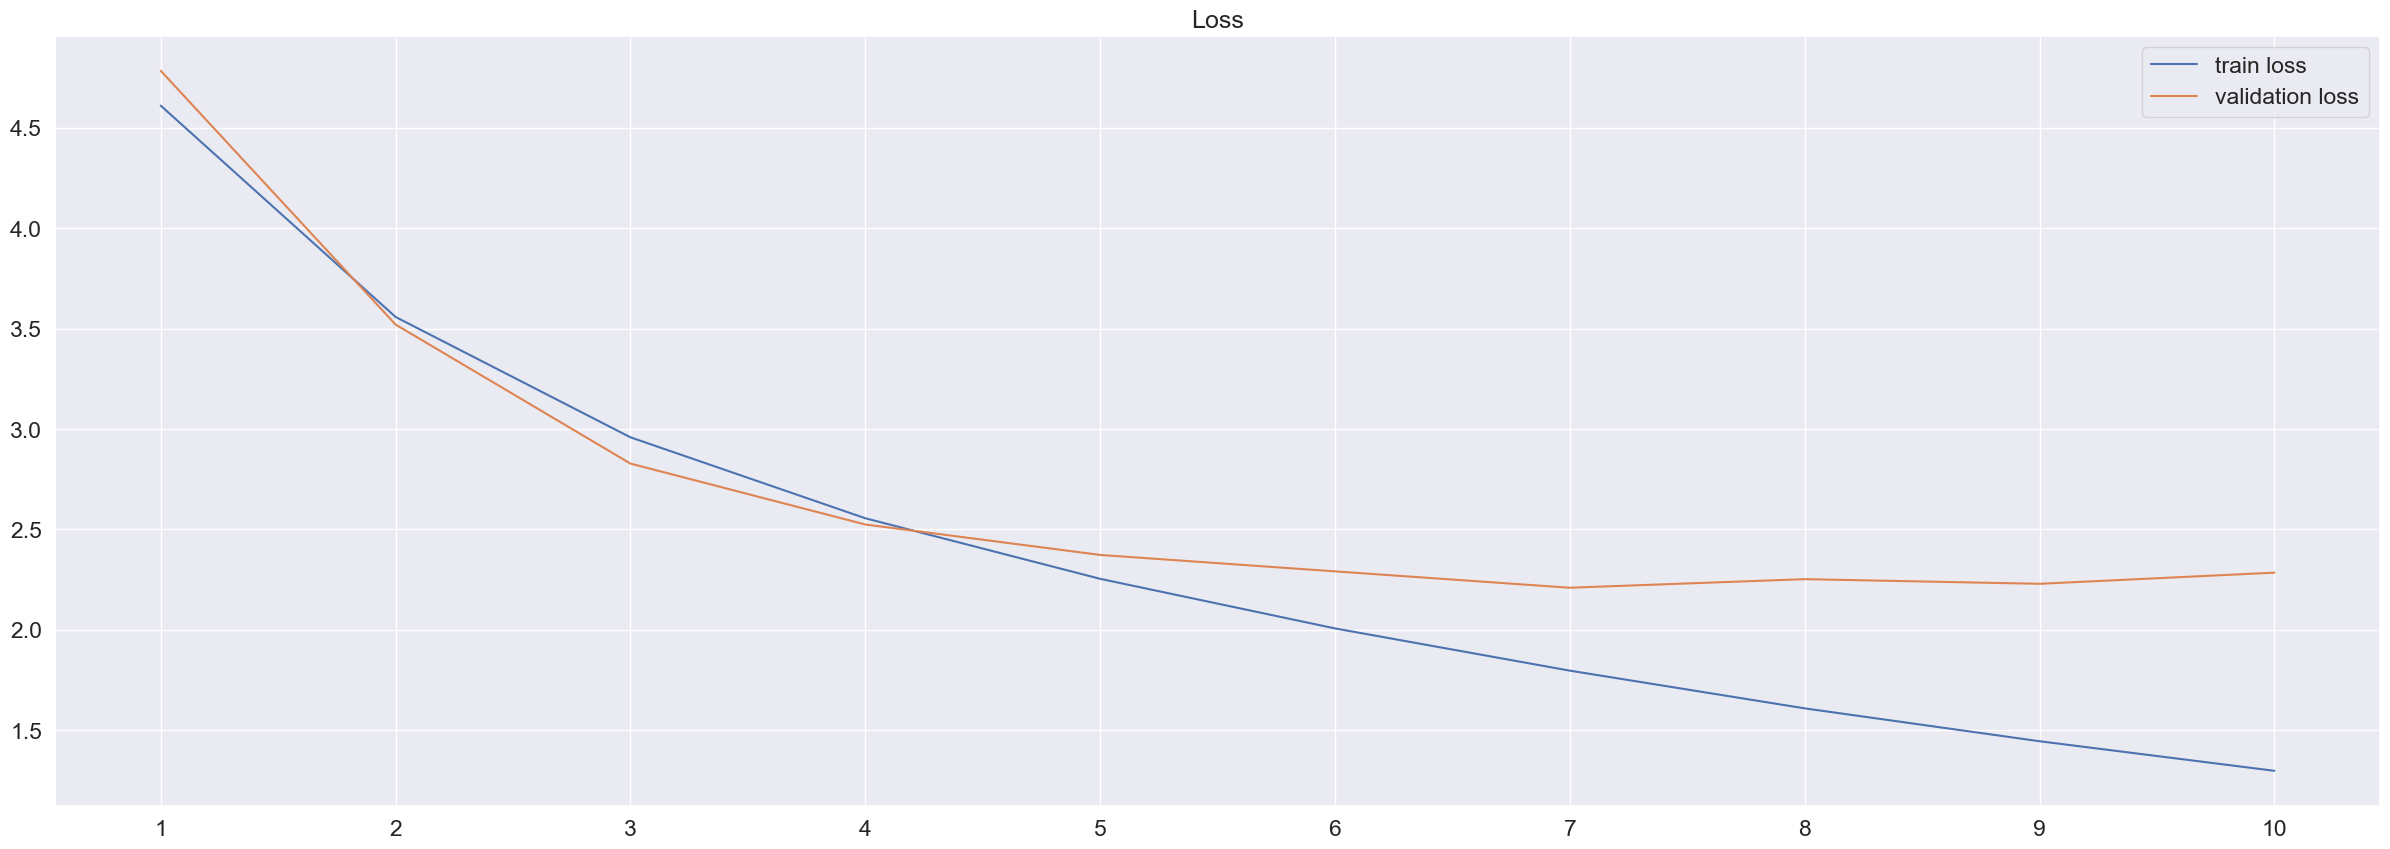

In [12]:
# plot
import pickle
save_folder = 'results/transformers'
with open(os.path.join(save_folder, 'stats_10.pkl'), 'rb') as f:
    stats = pickle.load(f)

epochs = 10
pd.set_option('display.precision', 2)
df_stats = pd.DataFrame(data=stats)
df_stats = df_stats.set_index('epoch')
sns.set(style='darkgrid')
sns.set(font_scale=1.5)

fig, axes = plt.subplots(1, 1, figsize=(30, 10))
axes.plot(df_stats['Training Loss'], label="train loss")
axes.plot(df_stats['Valid. Loss'], label="validation loss")
axes.set_title('Loss')
axes.set_xticks([i + 1 for i in range(epochs)])
axes.legend()
plt.show()

## Test

In [39]:
def predict_text(text,vocab_ger,vocab_eng,input_max_seq_length=42,target_max_seq_length=42):
    text = clean_ger_text(text)
    tokens = vocab_ger.generate_numeric_tokens(text)
    tokens = vocab_ger.add_eos_sos(tokens)
    tokens = vocab_ger.pad_sequence(tokens,max_seq_length=input_max_seq_length)
    ger_tensor = torch.tensor(tokens).unsqueeze(0)
    ger_tensor = ger_tensor.to(device)

    with torch.no_grad():
        encoder_out = model.encoder(ger_tensor)

    outputs = [vocab_eng.stoi["<SOS>"]]
    predicted_sentence = []

    for i in range(target_max_seq_length+2):

        output_tok = torch.LongTensor(outputs).unsqueeze(0).to(device)
        with torch.no_grad():
            out = model.decoder(output_tok,encoder_out)
            out = model.fc(out)

        out = out[:,-1,:]
        out = F.softmax(out)

        predicted_word_int = out.argmax(1).item()
        outputs.append(predicted_word_int)

        if predicted_word_int == vocab_eng.stoi["<EOS>"]:
             break

    predicted_sentence = [vocab_eng.itos[word_int] for word_int in outputs]
    predicted_sentence = predicted_sentence[1:]
    return ' '.join(predicted_sentence)


In [40]:
model_path= os.path.join(save_folder,'model_transformers.pt')
model.load_state_dict(torch.load(model_path,map_location=torch.device('cpu')))

<All keys matched successfully>

In [42]:
input = "Mehrere Frauen warten in einer Stadt im Freien."
pred = predict_text(input,vocab_ger,vocab_eng)
pred

'several women are waiting for a city street <EOS>'

In [64]:
from nltk.translate.bleu_score import sentence_bleu
score_sum = 0
count = 0
legth = 0
targets = []
df_test_score = df_test.loc[:10]
for i,data in enumerate(df_test_score.iterrows()):
   input = data[1]['Ger']
   target = data[1]['English']
   target_clean = clean_eng_text(target)
   targets.append([target_clean.split()])
   pred = predict_text(input,vocab_ger,vocab_eng)
   pred = pred.split()
   pred = ' '.join(pred[:-1])
   score = sentence_bleu([target_clean.split()],pred.split(),weights=(0.25, 0.25, 0.25, 0.25))
   score_sum += score
   int_ = random.randint(0,df_test_score.shape[0])
   if count < 10 and int_ < 100:
         print(f'Actual text: {input}')
         print(f'Actual output: {target}')
         print(f'Predicted text: {pred}')
         count += 1
         print(f'Bleu score: {score}')
         print('---'*20)


print(f'Average Bleu score: {score_sum/df_test_score.shape[0]}')


Actual text: Ein Mann mit einem orangefarbenen Hut der etwas anstarrt
Actual output: a man in an orange hat starring at something
Predicted text: a man in an orange hat is making something more effective
Bleu score: 0.47987820666906633
------------------------------------------------------------
Actual text: Ein Boston Terrier läuft über saftig-grünes Gras vor einem weißen Zaun
Actual output: a boston terrier is running on lush green grass in front of a white fence
Predicted text: a red and white dog is on the grass roots level of environmental considerations
Bleu score: 0.1
------------------------------------------------------------
Actual text: Ein Mädchen in einem Karateanzug bricht ein Brett mit einem Tritt
Actual output: a girl in karate uniform breaking a stick with a front kick
Predicted text: a good thing in a recent aviation safety is a priority
Bleu score: 0.1
------------------------------------------------------------
Actual text: Fünf Leute in Winterjacken und mit Helmen 

In [56]:
from nltk.translate.bleu_score import sentence_bleu
import nltk
nltk.download('punkt')

# Define the reference and candidate sentences
reference = ["two ladies and three men looking at the ocean".split()]
candidate = "two women and three men are looking at the link".split()

# Calculate BLEU score
bleu_score = sentence_bleu(reference, candidate)
print("BLEU Score:", bleu_score)


BLEU Score: 6.44985558187996e-78


[nltk_data] Downloading package punkt to
[nltk_data]     /Users/piaoshihao/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [44]:
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd

my_score = []
gpt4_score = []

my_trans = []
gpt4_trans = []
label_trans = []

to_show = []

for i in range(10):
    input = df_test.loc[i]['Ger']
    target = df_test.loc[i]['English']
    target_clean = clean_eng_text(target)
    pred = predict_text(input,vocab_ger,vocab_eng)
    pred = pred.split()
    pred = ' '.join(pred[:-1])
    score = sentence_bleu([target_clean.split()],pred.split(),weights=(0.25, 0.25, 0.25, 0.25))
    #score = sacrebleu.corpus_bleu([target_clean.split()],pred.split())
    my_score.append(score)
    my_trans.append(pred)
    label_trans.append(target_clean)

    if i == 3:
        to_show.append(input)
        to_show.append(target_clean)
        to_show.append(pred)
        to_show.append(score)

#A man with an orange hat staring at something.
#A Boston Terrier runs across lush green grass in front of a white fence.
#A girl in a karate suit breaks a board with a kick.
#Five people in winter jackets and helmets stand in the snow with snowmobiles in the background.
#People repairing the roof of a house.

gpt4_trans.append('A man with an orange hat staring at something.')
gpt4_trans.append('A Boston Terrier runs across lush green grass in front of a white fence.')
gpt4_trans.append('A girl in a karate suit breaks a board with a kick.')
gpt4_trans.append('Five people in winter jackets and helmets stand in the snow with snowmobiles in the background.')
gpt4_trans.append('People repairing the roof of a house.')

gpt4_trans.append('A brightly dressed man is photographing a group of men in dark suits and hats standing around a woman in a strapless dress.')
gpt4_trans.append('A group of people is standing in front of an igloo.')
gpt4_trans.append('A boy in a red jersey is trying to reach home base while the catcher in the blue jersey tries to catch him.')
gpt4_trans.append('A guy is working on a building.')
gpt4_trans.append('A man in a vest is sitting on a chair and holding magazines.')
gpt_score_avg = 0
for i in range(10):
    pred = gpt4_trans[i]
    pred = clean_eng_text(pred)
    pred = pred.split()
    pred = ' '.join(pred[:-1])
    target_clean = label_trans[i]
    score = sentence_bleu([target_clean.split()],pred.split(),weights=(0.25, 0.25, 0.25, 0.25))
    gpt4_score.append(score)
    gpt_score_avg += score
    if i == 3:
        to_show.append(pred)
        to_show.append(score)
print(gpt_score_avg/10)
df = pd.DataFrame({
    'Actual' : label_trans,
    'Translation': my_trans,
    'GPT-4': gpt4_trans,
    'Score': my_score,
    'GPT-4 Score': gpt4_score
})

# Display the DataFrame
print(df)
df.to_csv('showcase.csv')

0.385068532855502
                                              Actual  \
0       a man in an orange hat starring at something   
1  a boston terrier is running on lush green gras...   
2  a girl in karate uniform breaking a stick with...   
3  five people wearing winter jackets and helmets...   
4              people are fixing the roof of a house   
5  a man in light colored clothing photographs a ...   
6    a group of people standing in front of an igloo   
7  a boy in a red uniform is attempting to avoid ...   
8                          a guy works on a building   
9  a man in a vest is sitting in a chair and hold...   

                                         Translation  \
0  a man in an orange hat is making a little more...   
1  a red and white aviation has been <UNK> on the...   
2  girl in a recent thanks to the brenner baselev...   
3  five people in order to preserve their energy ...   
4  people are doing the work of the aviation indu...   
5  a lot of men in a group ta

In [61]:
!pip install sentencepiece

In [65]:
from transformers import MarianMTModel, MarianTokenizer
import sentencepiece

model_name = "Helsinki-NLP/opus-mt-de-en"
tokenizer = MarianTokenizer.from_pretrained(model_name)
model = MarianMTModel.from_pretrained(model_name)

In [59]:
!pip install transformers

In [70]:
from transformers import MarianMTModel, MarianTokenizer

def translate(text, model, tokenizer):
    # Tokenize the text
    batch = tokenizer(text, return_tensors="pt", padding=True, truncation=True, max_length=512)
    # Generate translation
    translated = model.generate(**batch)
    # Decode the translation
    translation = tokenizer.batch_decode(translated, skip_special_tokens=True)[0]
    return translation

# Load the model and tokenizer
model_name_base = "Helsinki-NLP/opus-mt-de-en"
tokenizer_base = MarianTokenizer.from_pretrained(model_name_base)
model_base = MarianMTModel.from_pretrained(model_name_base)
mar_score_avg = 0
for i in range(50):
    input = df_test.loc[i]['Ger']
    target = df_test.loc[i]['English']
    target_clean = clean_eng_text(target)
    pred = translate(input, model_base, tokenizer_base)
    pred = clean_eng_text(pred)
    pred = pred.split()
    pred = ' '.join(pred[:-1])
    score = sentence_bleu([target_clean.split()],pred.split(),weights=(0.25, 0.25, 0.25, 0.25))
    mar_score_avg += score
print(gpt_score_avg/50)




0.0770137065711004


In [24]:
print("German:",to_show[0])
print("English:",to_show[1])
print('\n')
print("My result:",to_show[2])
print("My score:",to_show[3])
print('\n')
print("Gpt4 result:",to_show[4])
print("Gpt4 score:",to_show[5])
print('\n')
print("MarianMT result:",to_show[6])
print("MarianMT score:",to_show[7])

German: Fünf Leute in Winterjacken und mit Helmen stehen im Schnee mit Schneemobilen im Hintergrund
English: five people wearing winter jackets and helmets stand in the snow with snowmobiles in the background


My result: five people in overalls and in the background are faced with <UNK>
My score: 3.2135170476591386e-78


Gpt4 result: five people in winter jackets and helmets stand in the snow with snowmobiles in the
Gpt4 score: 0.7710792371922995


MarianMT result: Five people in winter jackets and helmets standing in the snow with snowmobiles in the background
MarianMT score: 9.109159947227211e-232
